In [1]:
# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
# import keras modules
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [3]:
# import scikit-optimize modules
import skopt
from sklearn.preprocessing import MinMaxScaler
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Integer 
from skopt.plots import plot_convergence, plot_objective, plot_evaluations, plot_histogram, plot_objective_2D 
from skopt.utils import use_named_args

In [4]:
# check versions of libraries
print("Tensorflow: " + tf.__version__)
#print("Keras: " + tf.keras.__version__)
print("Skop: " + skopt.__version__)

Tensorflow: 2.13.0
Skop: 0.9.0


In [5]:
# set hyper-parameters
# learning rate
dim_learning_rate = Real(low=1e-3, high=1, prior='log-uniform', name='learning_rate')

# number of lstm layers
dim_num_lstm_units = Integer(low=1, high=500, name='num_lstm_units')

# number of epochs
dim_num_epochs = Integer(low=1, high=500, name='num_epochs')

# number of batch size
dim_num_batch_size = Integer(low=1, high=500, name='num_batch_size')

In [6]:
# combine hyper-parameters
dimensions = [dim_learning_rate, dim_num_lstm_units, dim_num_epochs, dim_num_batch_size]

In [7]:
# set default parameter values
default_parameters = [1e-2, 100, 100, 100]

In [8]:
# define a helper-function for log-dir-name
def log_dir_name(learning_rate, num_lstm_units,
                 num_epochs, num_batch_size):

    # the dir-name for the TensorBoard log-dir
    s = "./5_logs/lr_{0:.0e}_lstm_{1}_epochs_{2}_batch_{3}/"

    # insert all the hyper-parameters in the dir-name
    log_dir = s.format(learning_rate,
                       num_lstm_units,
                       num_epochs,
                       num_batch_size)

    return log_dir

In [9]:
df = pd.read_csv("C:/Users/Freddy H/Documents/Freddy/HydroAs Stage/donnee/donnee/Final_data.csv")

In [10]:
df['Precipitation'] = df['Precipitation_Affon']*0.25 +df['Precipitation_Béterou']*0.28 +df['Precipitation_Donga']*0.47

In [11]:
cols = list(df)
cols

['Time',
 'Temperature_Bétérou',
 'Pression',
 'Precipitation_Affon',
 'Precipitation_Béterou',
 'Precipitation_Donga',
 'Débit_Bétérou',
 'Precipitation']

In [12]:
df = df[['Time', 'Temperature_Bétérou', 'Pression', 'Precipitation', 'Débit_Bétérou']]

In [13]:
df['Time'] = pd.to_datetime(df['Time'])

In [125]:
# Nous allons entrainer et valider le modèle jusqu'en août 2020 et faire la prédiction de septembre jusqu'en décembre

data = df.iloc[:-122]
data2 = df.iloc[-122:]
data2

,Time,Temperature_Bétérou,Pression,Precipitation,Débit_Bétérou
7183,2020-09-01,296.84344,97138.650,22.0752,90.3454
7184,2020-09-02,297.84927,97010.414,2.3726,90.5383
7185,2020-09-03,298.54666,97140.290,21.7096,105.4400
7186,2020-09-04,298.90945,97342.375,0.1344,131.3667
7187,2020-09-05,296.44104,97210.460,67.3612,166.3083
...,...,...,...,...,...
7300,2020-12-27,299.02798,96949.320,0.0000,1.6232
7301,2020-12-28,298.98360,96970.940,0.0000,1.5464
7302,2020-12-29,299.33322,96920.310,0.0000,1.4899
7303,2020-12-30,299.63530,96983.600,0.0000,1.4349


In [126]:
 # Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Temperature_Bétérou', 'Pression', 'Precipitation', 'Débit_Bétérou']])
scaled_data2 = scaler.transform(data2[['Temperature_Bétérou', 'Pression', 'Precipitation', 'Débit_Bétérou']])

C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [127]:
def create_sequences(data, look_back=50):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back, -1])
    return np.array(X), np.array(y)

In [128]:
look_back = 50
X, y = create_sequences(scaled_data, look_back)

<Axes: >

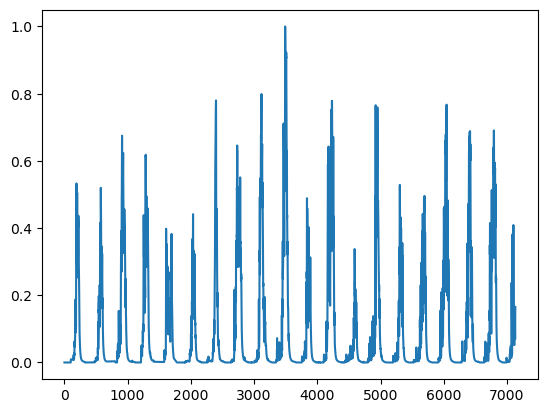

In [129]:
pd.Series(y).plot()

In [130]:
# Division en ensembles d'entraînement et de test
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = y[0:train_size], y[train_size:len(y)]

In [131]:
# Construction du modèle LSTM
def create_model(learning_rate, num_lstm_units, num_batch_size, num_epochs):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_lstm_units:    Number of lstm units.
    num_epochs:        Number of epochs.
    num_batch_size:    Batch size of model.
    """
    
    model = Sequential()
    model.add(LSTM(units=num_lstm_units, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(units=1))

    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

In [21]:
# save network with best hyper-parameters
path_best_model = '5_best_modelfuture.h5'

In [22]:
# set regression loss
best_loss = float('inf')

In [23]:
# Define function that creates and trains a neural network with the given hyper-parameters
# and then evaluates its performance on the validation-set
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_lstm_units, num_epochs, num_batch_size):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_lstm_units:    Number of lstm units.
    num_epochs:        Number of epochs.
    num_batch_size:    Batch size of model.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_lstm_units:', num_lstm_units)
    print('num_epochs:', num_epochs)
    print('num_batch_size:', num_batch_size)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_lstm_units=num_lstm_units,
                         num_epochs=num_epochs,
                         num_batch_size=num_batch_size)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_lstm_units,
                           num_epochs, num_batch_size)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x=trainX,
                        y=trainY,
                        epochs=num_epochs,
                        batch_size=num_batch_size,
                        validation_split=0.2,
                        verbose=2, 
                        shuffle=False,
                        callbacks=[callback_log])

    # Get the loss on the validation-set
    # after the last training-epoch.
    val_loss = history.history['val_loss'][-1]

    # print the classification accuracy.
    print()
    print("Loss: {0:.2%}".format(val_loss))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_loss

    # if the loss of the saved model is improved ...
    if val_loss < best_loss:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the loss.
        best_loss = val_loss

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # find a set of hyper-parameters with the LOWEST fitness-value
    return val_loss

In [32]:
# check run
fitness(x=default_parameters)

learning rate: 1.0e-02
num_lstm_units: 100
num_epochs: 100
num_batch_size: 100



Epoch 1/100
46/46 - 5s - loss: 0.0052 - mae: 0.0475 - val_loss: 0.0022 - val_mae: 0.0257 - 5s/epoch - 100ms/step
Epoch 2/100
46/46 - 2s - loss: 0.0019 - mae: 0.0241 - val_loss: 0.0019 - val_mae: 0.0231 - 2s/epoch - 53ms/step
Epoch 3/100
46/46 - 2s - loss: 0.0015 - mae: 0.0221 - val_loss: 0.0018 - val_mae: 0.0226 - 2s/epoch - 50ms/step
Epoch 4/100
46/46 - 2s - loss: 0.0013 - mae: 0.0211 - val_loss: 0.0016 - val_mae: 0.0210 - 2s/epoch - 46ms/step
Epoch 5/100
46/46 - 2s - loss: 0.0012 - mae: 0.0203 - val_loss: 0.0015 - val_mae: 0.0203 - 2s/epoch - 49ms/step
Epoch 6/100
46/46 - 2s - loss: 0.0011 - mae: 0.0195 - val_loss: 0.0015 - val_mae: 0.0205 - 2s/epoch - 48ms/step
Epoch 7/100
46/46 - 2s - loss: 0.0010 - mae: 0.0190 - val_loss: 0.0016 - val_mae: 0.0236 - 2s/epoch - 50ms/step
Epoch 8/100
46/46 - 3s - loss: 9.4807e-04 - mae: 0.0180 - val_loss: 0.0016 - val_mae: 0.0225 - 3s/epoch - 61ms/step
Epoch 9/100
46/46 - 3s - loss: 8.9488e-04 - mae: 0.0176 - val_loss: 0.0016 - val_mae: 0.0229 - 3s/e

Epoch 71/100
46/46 - 3s - loss: 3.2278e-04 - mae: 0.0095 - val_loss: 9.0856e-04 - val_mae: 0.0135 - 3s/epoch - 65ms/step
Epoch 72/100
46/46 - 3s - loss: 3.2250e-04 - mae: 0.0095 - val_loss: 9.0814e-04 - val_mae: 0.0135 - 3s/epoch - 67ms/step
Epoch 73/100
46/46 - 3s - loss: 3.2223e-04 - mae: 0.0094 - val_loss: 9.0778e-04 - val_mae: 0.0135 - 3s/epoch - 68ms/step
Epoch 74/100
46/46 - 3s - loss: 3.2195e-04 - mae: 0.0094 - val_loss: 9.0746e-04 - val_mae: 0.0135 - 3s/epoch - 65ms/step
Epoch 75/100
46/46 - 3s - loss: 3.2168e-04 - mae: 0.0094 - val_loss: 9.0717e-04 - val_mae: 0.0135 - 3s/epoch - 57ms/step
Epoch 76/100
46/46 - 3s - loss: 3.2141e-04 - mae: 0.0094 - val_loss: 9.0690e-04 - val_mae: 0.0135 - 3s/epoch - 57ms/step
Epoch 77/100
46/46 - 3s - loss: 3.2114e-04 - mae: 0.0094 - val_loss: 9.0664e-04 - val_mae: 0.0136 - 3s/epoch - 57ms/step
Epoch 78/100
46/46 - 2s - loss: 3.2087e-04 - mae: 0.0094 - val_loss: 9.0636e-04 - val_mae: 0.0136 - 2s/epoch - 53ms/step
Epoch 79/100
46/46 - 2s - loss: 

C:\Users\Freddy H\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.000862851447891444

In [57]:
##### run the hyper-parameter optimization
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=11,
                            x0=default_parameters)

learning rate: 1.0e-02
num_lstm_units: 100
num_epochs: 100
num_batch_size: 100



Epoch 1/100
46/46 - 4s - loss: 0.0084 - mae: 0.0567 - val_loss: 0.0027 - val_mae: 0.0297 - 4s/epoch - 91ms/step
Epoch 2/100
46/46 - 2s - loss: 0.0025 - mae: 0.0281 - val_loss: 0.0022 - val_mae: 0.0254 - 2s/epoch - 52ms/step
Epoch 3/100
46/46 - 3s - loss: 0.0020 - mae: 0.0255 - val_loss: 0.0020 - val_mae: 0.0238 - 3s/epoch - 70ms/step
Epoch 4/100
46/46 - 3s - loss: 0.0018 - mae: 0.0242 - val_loss: 0.0019 - val_mae: 0.0227 - 3s/epoch - 60ms/step
Epoch 5/100
46/46 - 3s - loss: 0.0016 - mae: 0.0232 - val_loss: 0.0018 - val_mae: 0.0219 - 3s/epoch - 58ms/step
Epoch 6/100
46/46 - 3s - loss: 0.0015 - mae: 0.0222 - val_loss: 0.0017 - val_mae: 0.0212 - 3s/epoch - 57ms/step
Epoch 7/100
46/46 - 3s - loss: 0.0013 - mae: 0.0213 - val_loss: 0.0016 - val_mae: 0.0205 - 3s/epoch - 60ms/step
Epoch 8/100
46/46 - 3s - loss: 0.0012 - mae: 0.0205 - val_loss: 0.0015 - val_mae: 0.0198 - 3s/epoch - 64ms/step
Epoch 9/100
46/46 - 2s - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0015 - val_mae: 0.0193 - 2s/epoch - 51

Epoch 71/100
46/46 - 3s - loss: 3.1945e-04 - mae: 0.0090 - val_loss: 9.9355e-04 - val_mae: 0.0155 - 3s/epoch - 60ms/step
Epoch 72/100
46/46 - 3s - loss: 3.3969e-04 - mae: 0.0099 - val_loss: 8.4487e-04 - val_mae: 0.0119 - 3s/epoch - 57ms/step
Epoch 73/100
46/46 - 3s - loss: 3.1913e-04 - mae: 0.0090 - val_loss: 9.9195e-04 - val_mae: 0.0155 - 3s/epoch - 57ms/step
Epoch 74/100
46/46 - 3s - loss: 3.3864e-04 - mae: 0.0099 - val_loss: 8.4424e-04 - val_mae: 0.0119 - 3s/epoch - 59ms/step
Epoch 75/100
46/46 - 3s - loss: 3.1883e-04 - mae: 0.0090 - val_loss: 9.9062e-04 - val_mae: 0.0154 - 3s/epoch - 58ms/step
Epoch 76/100
46/46 - 3s - loss: 3.3766e-04 - mae: 0.0099 - val_loss: 8.4378e-04 - val_mae: 0.0118 - 3s/epoch - 59ms/step
Epoch 77/100
46/46 - 3s - loss: 3.1853e-04 - mae: 0.0090 - val_loss: 9.8960e-04 - val_mae: 0.0154 - 3s/epoch - 61ms/step
Epoch 78/100
46/46 - 3s - loss: 3.3677e-04 - mae: 0.0099 - val_loss: 8.4344e-04 - val_mae: 0.0118 - 3s/epoch - 61ms/step
Epoch 79/100
46/46 - 3s - loss: 

Epoch 1/153
22/22 - 7s - loss: 0.0097 - mae: 0.0688 - val_loss: 0.0030 - val_mae: 0.0333 - 7s/epoch - 303ms/step
Epoch 2/153
22/22 - 3s - loss: 0.0032 - mae: 0.0372 - val_loss: 0.0026 - val_mae: 0.0314 - 3s/epoch - 133ms/step
Epoch 3/153
22/22 - 3s - loss: 0.0022 - mae: 0.0262 - val_loss: 0.0021 - val_mae: 0.0264 - 3s/epoch - 130ms/step
Epoch 4/153
22/22 - 2s - loss: 0.0019 - mae: 0.0242 - val_loss: 0.0020 - val_mae: 0.0266 - 2s/epoch - 112ms/step
Epoch 5/153
22/22 - 2s - loss: 0.0017 - mae: 0.0235 - val_loss: 0.0020 - val_mae: 0.0283 - 2s/epoch - 107ms/step
Epoch 6/153
22/22 - 2s - loss: 0.0017 - mae: 0.0234 - val_loss: 0.0020 - val_mae: 0.0296 - 2s/epoch - 108ms/step
Epoch 7/153
22/22 - 2s - loss: 0.0016 - mae: 0.0233 - val_loss: 0.0020 - val_mae: 0.0300 - 2s/epoch - 104ms/step
Epoch 8/153
22/22 - 3s - loss: 0.0015 - mae: 0.0230 - val_loss: 0.0019 - val_mae: 0.0299 - 3s/epoch - 122ms/step
Epoch 9/153
22/22 - 2s - loss: 0.0014 - mae: 0.0225 - val_loss: 0.0019 - val_mae: 0.0297 - 2s/ep

Epoch 71/153
22/22 - 2s - loss: 3.7777e-04 - mae: 0.0095 - val_loss: 8.7001e-04 - val_mae: 0.0124 - 2s/epoch - 105ms/step
Epoch 72/153
22/22 - 2s - loss: 3.7235e-04 - mae: 0.0093 - val_loss: 8.7710e-04 - val_mae: 0.0125 - 2s/epoch - 113ms/step
Epoch 73/153
22/22 - 2s - loss: 3.8739e-04 - mae: 0.0097 - val_loss: 8.6347e-04 - val_mae: 0.0122 - 2s/epoch - 100ms/step
Epoch 74/153
22/22 - 2s - loss: 3.9432e-04 - mae: 0.0098 - val_loss: 8.5449e-04 - val_mae: 0.0116 - 2s/epoch - 101ms/step
Epoch 75/153
22/22 - 2s - loss: 3.6999e-04 - mae: 0.0092 - val_loss: 8.5407e-04 - val_mae: 0.0115 - 2s/epoch - 102ms/step
Epoch 76/153
22/22 - 2s - loss: 3.4421e-04 - mae: 0.0088 - val_loss: 8.4099e-04 - val_mae: 0.0115 - 2s/epoch - 94ms/step
Epoch 77/153
22/22 - 2s - loss: 3.3979e-04 - mae: 0.0090 - val_loss: 8.3254e-04 - val_mae: 0.0113 - 2s/epoch - 96ms/step
Epoch 78/153
22/22 - 2s - loss: 3.4016e-04 - mae: 0.0091 - val_loss: 8.2740e-04 - val_mae: 0.0112 - 2s/epoch - 95ms/step
Epoch 79/153
22/22 - 2s - l

Epoch 138/153
22/22 - 3s - loss: 3.0232e-04 - mae: 0.0077 - val_loss: 8.2434e-04 - val_mae: 0.0102 - 3s/epoch - 119ms/step
Epoch 139/153
22/22 - 2s - loss: 3.0248e-04 - mae: 0.0078 - val_loss: 8.3262e-04 - val_mae: 0.0106 - 2s/epoch - 99ms/step
Epoch 140/153
22/22 - 2s - loss: 2.9663e-04 - mae: 0.0080 - val_loss: 8.3579e-04 - val_mae: 0.0106 - 2s/epoch - 110ms/step
Epoch 141/153
22/22 - 3s - loss: 2.9428e-04 - mae: 0.0080 - val_loss: 8.2503e-04 - val_mae: 0.0107 - 3s/epoch - 127ms/step
Epoch 142/153
22/22 - 2s - loss: 2.9221e-04 - mae: 0.0079 - val_loss: 8.3295e-04 - val_mae: 0.0106 - 2s/epoch - 111ms/step
Epoch 143/153
22/22 - 3s - loss: 2.9434e-04 - mae: 0.0078 - val_loss: 8.3776e-04 - val_mae: 0.0104 - 3s/epoch - 122ms/step
Epoch 144/153
22/22 - 3s - loss: 2.9741e-04 - mae: 0.0077 - val_loss: 8.1773e-04 - val_mae: 0.0101 - 3s/epoch - 126ms/step
Epoch 145/153
22/22 - 2s - loss: 2.9706e-04 - mae: 0.0076 - val_loss: 8.2283e-04 - val_mae: 0.0102 - 2s/epoch - 112ms/step
Epoch 146/153
22/

C:\Users\Freddy H\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/99
13/13 - 8s - loss: 0.0091 - mae: 0.0682 - val_loss: 0.0029 - val_mae: 0.0326 - 8s/epoch - 609ms/step
Epoch 2/99
13/13 - 4s - loss: 0.0031 - mae: 0.0350 - val_loss: 0.0025 - val_mae: 0.0313 - 4s/epoch - 293ms/step
Epoch 3/99
13/13 - 4s - loss: 0.0022 - mae: 0.0296 - val_loss: 0.0021 - val_mae: 0.0276 - 4s/epoch - 297ms/step
Epoch 4/99
13/13 - 4s - loss: 0.0018 - mae: 0.0237 - val_loss: 0.0019 - val_mae: 0.0224 - 4s/epoch - 304ms/step
Epoch 5/99
13/13 - 4s - loss: 0.0016 - mae: 0.0215 - val_loss: 0.0019 - val_mae: 0.0229 - 4s/epoch - 302ms/step
Epoch 6/99
13/13 - 4s - loss: 0.0015 - mae: 0.0212 - val_loss: 0.0018 - val_mae: 0.0230 - 4s/epoch - 309ms/step
Epoch 7/99
13/13 - 4s - loss: 0.0014 - mae: 0.0207 - val_loss: 0.0017 - val_mae: 0.0221 - 4s/epoch - 325ms/step
Epoch 8/99
13/13 - 4s - loss: 0.0014 - mae: 0.0200 - val_loss: 0.0017 - val_mae: 0.0222 - 4s/epoch - 314ms/step
Epoch 9/99
13/13 - 5s - loss: 0.0013 - mae: 0.0196 - val_loss: 0.0016 - val_mae: 0.0222 - 5s/epoch - 357

Epoch 72/99
13/13 - 5s - loss: 3.5861e-04 - mae: 0.0093 - val_loss: 9.0686e-04 - val_mae: 0.0141 - 5s/epoch - 380ms/step
Epoch 73/99
13/13 - 5s - loss: 3.7210e-04 - mae: 0.0099 - val_loss: 9.8098e-04 - val_mae: 0.0143 - 5s/epoch - 393ms/step
Epoch 74/99
13/13 - 5s - loss: 4.3562e-04 - mae: 0.0118 - val_loss: 8.9200e-04 - val_mae: 0.0121 - 5s/epoch - 366ms/step
Epoch 75/99
13/13 - 5s - loss: 3.7875e-04 - mae: 0.0094 - val_loss: 9.1510e-04 - val_mae: 0.0120 - 5s/epoch - 353ms/step
Epoch 76/99
13/13 - 5s - loss: 3.5253e-04 - mae: 0.0092 - val_loss: 8.8769e-04 - val_mae: 0.0140 - 5s/epoch - 347ms/step
Epoch 77/99
13/13 - 5s - loss: 3.6951e-04 - mae: 0.0099 - val_loss: 9.1005e-04 - val_mae: 0.0133 - 5s/epoch - 354ms/step
Epoch 78/99
13/13 - 6s - loss: 4.0090e-04 - mae: 0.0109 - val_loss: 8.7575e-04 - val_mae: 0.0120 - 6s/epoch - 442ms/step
Epoch 79/99
13/13 - 8s - loss: 3.5251e-04 - mae: 0.0091 - val_loss: 8.8637e-04 - val_mae: 0.0120 - 8s/epoch - 596ms/step
Epoch 80/99
13/13 - 7s - loss: 3

Epoch 1/230
56/56 - 8s - loss: 0.0072 - mae: 0.0528 - val_loss: 0.0023 - val_mae: 0.0273 - 8s/epoch - 152ms/step
Epoch 2/230
56/56 - 6s - loss: 0.0021 - mae: 0.0254 - val_loss: 0.0019 - val_mae: 0.0218 - 6s/epoch - 111ms/step
Epoch 3/230
56/56 - 6s - loss: 0.0017 - mae: 0.0236 - val_loss: 0.0017 - val_mae: 0.0207 - 6s/epoch - 112ms/step
Epoch 4/230
56/56 - 6s - loss: 0.0015 - mae: 0.0223 - val_loss: 0.0016 - val_mae: 0.0196 - 6s/epoch - 112ms/step
Epoch 5/230
56/56 - 8s - loss: 0.0014 - mae: 0.0215 - val_loss: 0.0016 - val_mae: 0.0193 - 8s/epoch - 151ms/step
Epoch 6/230
56/56 - 6s - loss: 0.0012 - mae: 0.0207 - val_loss: 0.0015 - val_mae: 0.0191 - 6s/epoch - 104ms/step
Epoch 7/230
56/56 - 6s - loss: 0.0011 - mae: 0.0199 - val_loss: 0.0015 - val_mae: 0.0188 - 6s/epoch - 110ms/step
Epoch 8/230
56/56 - 8s - loss: 0.0011 - mae: 0.0192 - val_loss: 0.0014 - val_mae: 0.0187 - 8s/epoch - 143ms/step
Epoch 9/230
56/56 - 7s - loss: 9.9234e-04 - mae: 0.0185 - val_loss: 0.0014 - val_mae: 0.0186 - 7

Epoch 70/230
56/56 - 5s - loss: 3.2778e-04 - mae: 0.0092 - val_loss: 8.1544e-04 - val_mae: 0.0115 - 5s/epoch - 95ms/step
Epoch 71/230
56/56 - 6s - loss: 3.2503e-04 - mae: 0.0091 - val_loss: 8.2370e-04 - val_mae: 0.0112 - 6s/epoch - 99ms/step
Epoch 72/230
56/56 - 5s - loss: 3.2686e-04 - mae: 0.0091 - val_loss: 8.1761e-04 - val_mae: 0.0114 - 5s/epoch - 95ms/step
Epoch 73/230
56/56 - 6s - loss: 3.2366e-04 - mae: 0.0090 - val_loss: 8.3895e-04 - val_mae: 0.0112 - 6s/epoch - 113ms/step
Epoch 74/230
56/56 - 5s - loss: 3.2906e-04 - mae: 0.0092 - val_loss: 8.1762e-04 - val_mae: 0.0115 - 5s/epoch - 90ms/step
Epoch 75/230
56/56 - 7s - loss: 3.2390e-04 - mae: 0.0090 - val_loss: 8.4595e-04 - val_mae: 0.0110 - 7s/epoch - 116ms/step
Epoch 76/230
56/56 - 6s - loss: 3.2594e-04 - mae: 0.0091 - val_loss: 8.7060e-04 - val_mae: 0.0115 - 6s/epoch - 111ms/step
Epoch 77/230
56/56 - 6s - loss: 3.2705e-04 - mae: 0.0091 - val_loss: 9.1898e-04 - val_mae: 0.0119 - 6s/epoch - 103ms/step
Epoch 78/230
56/56 - 6s - lo

Epoch 138/230
56/56 - 6s - loss: 3.0838e-04 - mae: 0.0089 - val_loss: 8.1909e-04 - val_mae: 0.0103 - 6s/epoch - 112ms/step
Epoch 139/230
56/56 - 6s - loss: 2.8467e-04 - mae: 0.0079 - val_loss: 8.9008e-04 - val_mae: 0.0116 - 6s/epoch - 108ms/step
Epoch 140/230
56/56 - 6s - loss: 2.8674e-04 - mae: 0.0083 - val_loss: 8.3121e-04 - val_mae: 0.0107 - 6s/epoch - 106ms/step
Epoch 141/230
56/56 - 6s - loss: 2.8096e-04 - mae: 0.0079 - val_loss: 8.8691e-04 - val_mae: 0.0117 - 6s/epoch - 104ms/step
Epoch 142/230
56/56 - 6s - loss: 2.8452e-04 - mae: 0.0083 - val_loss: 8.3574e-04 - val_mae: 0.0112 - 6s/epoch - 107ms/step
Epoch 143/230
56/56 - 6s - loss: 2.8054e-04 - mae: 0.0081 - val_loss: 8.7450e-04 - val_mae: 0.0118 - 6s/epoch - 108ms/step
Epoch 144/230
56/56 - 6s - loss: 2.8281e-04 - mae: 0.0083 - val_loss: 8.6471e-04 - val_mae: 0.0118 - 6s/epoch - 109ms/step
Epoch 145/230
56/56 - 6s - loss: 2.8360e-04 - mae: 0.0084 - val_loss: 8.7272e-04 - val_mae: 0.0119 - 6s/epoch - 107ms/step
Epoch 146/230
56

Epoch 205/230
56/56 - 7s - loss: 2.2399e-04 - mae: 0.0074 - val_loss: 8.9286e-04 - val_mae: 0.0116 - 7s/epoch - 118ms/step
Epoch 206/230
56/56 - 6s - loss: 2.3372e-04 - mae: 0.0078 - val_loss: 8.9084e-04 - val_mae: 0.0117 - 6s/epoch - 114ms/step
Epoch 207/230
56/56 - 7s - loss: 2.3940e-04 - mae: 0.0078 - val_loss: 8.2812e-04 - val_mae: 0.0110 - 7s/epoch - 118ms/step
Epoch 208/230
56/56 - 7s - loss: 2.2365e-04 - mae: 0.0075 - val_loss: 8.9451e-04 - val_mae: 0.0118 - 7s/epoch - 126ms/step
Epoch 209/230
56/56 - 6s - loss: 2.2694e-04 - mae: 0.0077 - val_loss: 9.9445e-04 - val_mae: 0.0127 - 6s/epoch - 115ms/step
Epoch 210/230
56/56 - 6s - loss: 3.3507e-04 - mae: 0.0105 - val_loss: 9.6174e-04 - val_mae: 0.0141 - 6s/epoch - 114ms/step
Epoch 211/230
56/56 - 6s - loss: 2.7782e-04 - mae: 0.0090 - val_loss: 8.2615e-04 - val_mae: 0.0110 - 6s/epoch - 108ms/step
Epoch 212/230
56/56 - 6s - loss: 2.3454e-04 - mae: 0.0075 - val_loss: 9.1640e-04 - val_mae: 0.0116 - 6s/epoch - 113ms/step
Epoch 213/230
56

Epoch 1/369
10/10 - 11s - loss: 0.0155 - mae: 0.0903 - val_loss: 0.0071 - val_mae: 0.0664 - 11s/epoch - 1s/step
Epoch 2/369
10/10 - 8s - loss: 0.0060 - mae: 0.0549 - val_loss: 0.0058 - val_mae: 0.0692 - 8s/epoch - 758ms/step
Epoch 3/369
10/10 - 8s - loss: 0.0035 - mae: 0.0440 - val_loss: 0.0025 - val_mae: 0.0312 - 8s/epoch - 760ms/step
Epoch 4/369
10/10 - 8s - loss: 0.0024 - mae: 0.0300 - val_loss: 0.0023 - val_mae: 0.0259 - 8s/epoch - 751ms/step
Epoch 5/369
10/10 - 7s - loss: 0.0019 - mae: 0.0245 - val_loss: 0.0019 - val_mae: 0.0239 - 7s/epoch - 745ms/step
Epoch 6/369
10/10 - 8s - loss: 0.0017 - mae: 0.0243 - val_loss: 0.0020 - val_mae: 0.0246 - 8s/epoch - 758ms/step
Epoch 7/369
10/10 - 8s - loss: 0.0016 - mae: 0.0221 - val_loss: 0.0018 - val_mae: 0.0218 - 8s/epoch - 757ms/step
Epoch 8/369
10/10 - 8s - loss: 0.0015 - mae: 0.0212 - val_loss: 0.0018 - val_mae: 0.0228 - 8s/epoch - 754ms/step
Epoch 9/369
10/10 - 7s - loss: 0.0015 - mae: 0.0209 - val_loss: 0.0017 - val_mae: 0.0220 - 7s/epo

Epoch 72/369
10/10 - 8s - loss: 5.4575e-04 - mae: 0.0144 - val_loss: 0.0012 - val_mae: 0.0148 - 8s/epoch - 796ms/step
Epoch 73/369
10/10 - 8s - loss: 5.2544e-04 - mae: 0.0142 - val_loss: 0.0012 - val_mae: 0.0140 - 8s/epoch - 817ms/step
Epoch 74/369
10/10 - 8s - loss: 4.8187e-04 - mae: 0.0129 - val_loss: 0.0012 - val_mae: 0.0142 - 8s/epoch - 784ms/step
Epoch 75/369
10/10 - 8s - loss: 4.4192e-04 - mae: 0.0113 - val_loss: 0.0011 - val_mae: 0.0138 - 8s/epoch - 759ms/step
Epoch 76/369
10/10 - 8s - loss: 4.3471e-04 - mae: 0.0105 - val_loss: 0.0011 - val_mae: 0.0130 - 8s/epoch - 758ms/step
Epoch 77/369
10/10 - 9s - loss: 4.2453e-04 - mae: 0.0102 - val_loss: 0.0010 - val_mae: 0.0130 - 9s/epoch - 882ms/step
Epoch 78/369
10/10 - 8s - loss: 4.3761e-04 - mae: 0.0103 - val_loss: 0.0011 - val_mae: 0.0139 - 8s/epoch - 772ms/step
Epoch 79/369
10/10 - 8s - loss: 4.9938e-04 - mae: 0.0119 - val_loss: 0.0011 - val_mae: 0.0140 - 8s/epoch - 770ms/step
Epoch 80/369
10/10 - 8s - loss: 5.0128e-04 - mae: 0.0115

Epoch 140/369
10/10 - 9s - loss: 3.0927e-04 - mae: 0.0080 - val_loss: 8.4003e-04 - val_mae: 0.0106 - 9s/epoch - 854ms/step
Epoch 141/369
10/10 - 9s - loss: 3.0764e-04 - mae: 0.0080 - val_loss: 8.2609e-04 - val_mae: 0.0105 - 9s/epoch - 919ms/step
Epoch 142/369
10/10 - 9s - loss: 3.1291e-04 - mae: 0.0081 - val_loss: 8.4369e-04 - val_mae: 0.0107 - 9s/epoch - 883ms/step
Epoch 143/369
10/10 - 9s - loss: 3.0759e-04 - mae: 0.0080 - val_loss: 8.2810e-04 - val_mae: 0.0105 - 9s/epoch - 873ms/step
Epoch 144/369
10/10 - 8s - loss: 3.1080e-04 - mae: 0.0080 - val_loss: 8.4451e-04 - val_mae: 0.0107 - 8s/epoch - 850ms/step
Epoch 145/369
10/10 - 9s - loss: 3.0835e-04 - mae: 0.0080 - val_loss: 8.2897e-04 - val_mae: 0.0105 - 9s/epoch - 861ms/step
Epoch 146/369
10/10 - 9s - loss: 3.1096e-04 - mae: 0.0081 - val_loss: 8.4463e-04 - val_mae: 0.0107 - 9s/epoch - 852ms/step
Epoch 147/369
10/10 - 9s - loss: 3.0936e-04 - mae: 0.0081 - val_loss: 8.3010e-04 - val_mae: 0.0106 - 9s/epoch - 854ms/step
Epoch 148/369
10

Epoch 207/369
10/10 - 9s - loss: 3.0709e-04 - mae: 0.0079 - val_loss: 8.7673e-04 - val_mae: 0.0105 - 9s/epoch - 855ms/step
Epoch 208/369
10/10 - 8s - loss: 3.0444e-04 - mae: 0.0076 - val_loss: 8.8175e-04 - val_mae: 0.0104 - 8s/epoch - 847ms/step
Epoch 209/369
10/10 - 8s - loss: 3.0131e-04 - mae: 0.0075 - val_loss: 8.7751e-04 - val_mae: 0.0105 - 8s/epoch - 816ms/step
Epoch 210/369
10/10 - 8s - loss: 2.9859e-04 - mae: 0.0076 - val_loss: 8.7544e-04 - val_mae: 0.0107 - 8s/epoch - 840ms/step
Epoch 211/369
10/10 - 8s - loss: 2.9579e-04 - mae: 0.0076 - val_loss: 8.7853e-04 - val_mae: 0.0108 - 8s/epoch - 823ms/step
Epoch 212/369
10/10 - 8s - loss: 2.9377e-04 - mae: 0.0076 - val_loss: 8.8153e-04 - val_mae: 0.0110 - 8s/epoch - 798ms/step
Epoch 213/369
10/10 - 8s - loss: 2.9273e-04 - mae: 0.0077 - val_loss: 8.8649e-04 - val_mae: 0.0113 - 8s/epoch - 769ms/step
Epoch 214/369
10/10 - 7s - loss: 2.9337e-04 - mae: 0.0078 - val_loss: 8.8728e-04 - val_mae: 0.0115 - 7s/epoch - 730ms/step
Epoch 215/369
10

Epoch 274/369
10/10 - 8s - loss: 2.7533e-04 - mae: 0.0075 - val_loss: 9.6099e-04 - val_mae: 0.0115 - 8s/epoch - 829ms/step
Epoch 275/369
10/10 - 8s - loss: 2.7441e-04 - mae: 0.0073 - val_loss: 9.8936e-04 - val_mae: 0.0117 - 8s/epoch - 833ms/step
Epoch 276/369
10/10 - 9s - loss: 2.7356e-04 - mae: 0.0073 - val_loss: 9.7535e-04 - val_mae: 0.0115 - 9s/epoch - 857ms/step
Epoch 277/369
10/10 - 8s - loss: 2.7223e-04 - mae: 0.0073 - val_loss: 9.7674e-04 - val_mae: 0.0113 - 8s/epoch - 840ms/step
Epoch 278/369
10/10 - 9s - loss: 2.7088e-04 - mae: 0.0074 - val_loss: 9.6604e-04 - val_mae: 0.0113 - 9s/epoch - 879ms/step
Epoch 279/369
10/10 - 9s - loss: 2.7460e-04 - mae: 0.0072 - val_loss: 9.8133e-04 - val_mae: 0.0118 - 9s/epoch - 873ms/step
Epoch 280/369
10/10 - 9s - loss: 2.7699e-04 - mae: 0.0078 - val_loss: 9.7454e-04 - val_mae: 0.0120 - 9s/epoch - 944ms/step
Epoch 281/369
10/10 - 8s - loss: 2.7272e-04 - mae: 0.0076 - val_loss: 9.4636e-04 - val_mae: 0.0110 - 8s/epoch - 813ms/step
Epoch 282/369
10

10/10 - 8s - loss: 2.5962e-04 - mae: 0.0072 - val_loss: 9.8166e-04 - val_mae: 0.0114 - 8s/epoch - 794ms/step
Epoch 342/369
10/10 - 8s - loss: 2.5671e-04 - mae: 0.0073 - val_loss: 0.0010 - val_mae: 0.0126 - 8s/epoch - 821ms/step
Epoch 343/369
10/10 - 8s - loss: 2.5521e-04 - mae: 0.0075 - val_loss: 9.5507e-04 - val_mae: 0.0118 - 8s/epoch - 772ms/step
Epoch 344/369
10/10 - 7s - loss: 2.6504e-04 - mae: 0.0075 - val_loss: 8.9494e-04 - val_mae: 0.0112 - 7s/epoch - 741ms/step
Epoch 345/369
10/10 - 8s - loss: 2.6132e-04 - mae: 0.0076 - val_loss: 9.2655e-04 - val_mae: 0.0122 - 8s/epoch - 760ms/step
Epoch 346/369
10/10 - 7s - loss: 2.5829e-04 - mae: 0.0074 - val_loss: 0.0011 - val_mae: 0.0124 - 7s/epoch - 744ms/step
Epoch 347/369
10/10 - 8s - loss: 2.7359e-04 - mae: 0.0078 - val_loss: 9.6931e-04 - val_mae: 0.0129 - 8s/epoch - 764ms/step
Epoch 348/369
10/10 - 7s - loss: 2.6924e-04 - mae: 0.0082 - val_loss: 9.3730e-04 - val_mae: 0.0121 - 7s/epoch - 715ms/step
Epoch 349/369
10/10 - 7s - loss: 2.684

Epoch 1/136
52/52 - 5s - loss: 0.0218 - mae: 0.1090 - val_loss: 0.0174 - val_mae: 0.1036 - 5s/epoch - 88ms/step
Epoch 2/136
52/52 - 1s - loss: 0.0160 - mae: 0.0942 - val_loss: 0.0146 - val_mae: 0.0953 - 840ms/epoch - 16ms/step
Epoch 3/136
52/52 - 1s - loss: 0.0123 - mae: 0.0837 - val_loss: 0.0121 - val_mae: 0.0868 - 754ms/epoch - 15ms/step
Epoch 4/136
52/52 - 1s - loss: 0.0096 - mae: 0.0734 - val_loss: 0.0097 - val_mae: 0.0768 - 781ms/epoch - 15ms/step
Epoch 5/136
52/52 - 1s - loss: 0.0074 - mae: 0.0633 - val_loss: 0.0076 - val_mae: 0.0664 - 780ms/epoch - 15ms/step
Epoch 6/136
52/52 - 1s - loss: 0.0058 - mae: 0.0539 - val_loss: 0.0061 - val_mae: 0.0573 - 743ms/epoch - 14ms/step
Epoch 7/136
52/52 - 1s - loss: 0.0048 - mae: 0.0470 - val_loss: 0.0053 - val_mae: 0.0523 - 754ms/epoch - 14ms/step
Epoch 8/136
52/52 - 1s - loss: 0.0043 - mae: 0.0434 - val_loss: 0.0048 - val_mae: 0.0490 - 771ms/epoch - 15ms/step
Epoch 9/136
52/52 - 1s - loss: 0.0039 - mae: 0.0410 - val_loss: 0.0044 - val_mae: 0

Epoch 71/136
52/52 - 1s - loss: 6.8037e-04 - mae: 0.0133 - val_loss: 0.0013 - val_mae: 0.0172 - 868ms/epoch - 17ms/step
Epoch 72/136
52/52 - 1s - loss: 6.7290e-04 - mae: 0.0132 - val_loss: 0.0012 - val_mae: 0.0171 - 808ms/epoch - 16ms/step
Epoch 73/136
52/52 - 1s - loss: 6.6561e-04 - mae: 0.0131 - val_loss: 0.0012 - val_mae: 0.0170 - 896ms/epoch - 17ms/step
Epoch 74/136
52/52 - 1s - loss: 6.5851e-04 - mae: 0.0130 - val_loss: 0.0012 - val_mae: 0.0169 - 836ms/epoch - 16ms/step
Epoch 75/136
52/52 - 1s - loss: 6.5158e-04 - mae: 0.0129 - val_loss: 0.0012 - val_mae: 0.0168 - 971ms/epoch - 19ms/step
Epoch 76/136
52/52 - 1s - loss: 6.4481e-04 - mae: 0.0128 - val_loss: 0.0012 - val_mae: 0.0167 - 920ms/epoch - 18ms/step
Epoch 77/136
52/52 - 1s - loss: 6.3821e-04 - mae: 0.0127 - val_loss: 0.0012 - val_mae: 0.0166 - 1s/epoch - 20ms/step
Epoch 78/136
52/52 - 1s - loss: 6.3177e-04 - mae: 0.0126 - val_loss: 0.0012 - val_mae: 0.0166 - 1s/epoch - 28ms/step
Epoch 79/136
52/52 - 1s - loss: 6.2548e-04 - m

Epoch 1/16
11/11 - 14s - loss: 0.0155 - mae: 0.0895 - val_loss: 0.0046 - val_mae: 0.0521 - 14s/epoch - 1s/step
Epoch 2/16
11/11 - 9s - loss: 0.0053 - mae: 0.0518 - val_loss: 0.0056 - val_mae: 0.0675 - 9s/epoch - 778ms/step
Epoch 3/16
11/11 - 9s - loss: 0.0032 - mae: 0.0418 - val_loss: 0.0021 - val_mae: 0.0244 - 9s/epoch - 778ms/step
Epoch 4/16
11/11 - 9s - loss: 0.0021 - mae: 0.0292 - val_loss: 0.0020 - val_mae: 0.0242 - 9s/epoch - 795ms/step
Epoch 5/16
11/11 - 9s - loss: 0.0017 - mae: 0.0239 - val_loss: 0.0019 - val_mae: 0.0231 - 9s/epoch - 835ms/step
Epoch 6/16
11/11 - 10s - loss: 0.0016 - mae: 0.0210 - val_loss: 0.0018 - val_mae: 0.0221 - 10s/epoch - 895ms/step
Epoch 7/16
11/11 - 10s - loss: 0.0015 - mae: 0.0210 - val_loss: 0.0017 - val_mae: 0.0209 - 10s/epoch - 883ms/step
Epoch 8/16
11/11 - 10s - loss: 0.0014 - mae: 0.0197 - val_loss: 0.0017 - val_mae: 0.0217 - 10s/epoch - 897ms/step
Epoch 9/16
11/11 - 10s - loss: 0.0013 - mae: 0.0202 - val_loss: 0.0016 - val_mae: 0.0204 - 10s/epoc

Epoch 1/261
11/11 - 14s - loss: 0.0219 - mae: 0.1008 - val_loss: 0.0059 - val_mae: 0.0611 - 14s/epoch - 1s/step
Epoch 2/261
11/11 - 12s - loss: 0.0065 - mae: 0.0585 - val_loss: 0.0064 - val_mae: 0.0741 - 12s/epoch - 1s/step
Epoch 3/261
11/11 - 12s - loss: 0.0037 - mae: 0.0453 - val_loss: 0.0022 - val_mae: 0.0239 - 12s/epoch - 1s/step
Epoch 4/261
11/11 - 12s - loss: 0.0022 - mae: 0.0306 - val_loss: 0.0021 - val_mae: 0.0240 - 12s/epoch - 1s/step
Epoch 5/261
11/11 - 11s - loss: 0.0020 - mae: 0.0264 - val_loss: 0.0022 - val_mae: 0.0286 - 11s/epoch - 1s/step
Epoch 6/261
11/11 - 11s - loss: 0.0018 - mae: 0.0235 - val_loss: 0.0018 - val_mae: 0.0216 - 11s/epoch - 965ms/step
Epoch 7/261
11/11 - 12s - loss: 0.0016 - mae: 0.0213 - val_loss: 0.0018 - val_mae: 0.0223 - 12s/epoch - 1s/step
Epoch 8/261
11/11 - 11s - loss: 0.0015 - mae: 0.0221 - val_loss: 0.0018 - val_mae: 0.0220 - 11s/epoch - 1s/step
Epoch 9/261
11/11 - 10s - loss: 0.0015 - mae: 0.0211 - val_loss: 0.0017 - val_mae: 0.0210 - 10s/epoch

Epoch 72/261
11/11 - 24s - loss: 4.7442e-04 - mae: 0.0108 - val_loss: 0.0011 - val_mae: 0.0136 - 24s/epoch - 2s/step
Epoch 73/261
11/11 - 24s - loss: 4.4827e-04 - mae: 0.0103 - val_loss: 0.0011 - val_mae: 0.0131 - 24s/epoch - 2s/step
Epoch 74/261
11/11 - 24s - loss: 5.0172e-04 - mae: 0.0111 - val_loss: 0.0012 - val_mae: 0.0151 - 24s/epoch - 2s/step
Epoch 75/261
11/11 - 23s - loss: 6.4937e-04 - mae: 0.0131 - val_loss: 0.0013 - val_mae: 0.0187 - 23s/epoch - 2s/step
Epoch 76/261
11/11 - 24s - loss: 5.6928e-04 - mae: 0.0141 - val_loss: 0.0012 - val_mae: 0.0177 - 24s/epoch - 2s/step
Epoch 77/261
11/11 - 24s - loss: 5.4220e-04 - mae: 0.0136 - val_loss: 0.0011 - val_mae: 0.0136 - 24s/epoch - 2s/step
Epoch 78/261
11/11 - 24s - loss: 4.8433e-04 - mae: 0.0111 - val_loss: 0.0011 - val_mae: 0.0131 - 24s/epoch - 2s/step
Epoch 79/261
11/11 - 24s - loss: 4.6410e-04 - mae: 0.0107 - val_loss: 0.0012 - val_mae: 0.0141 - 24s/epoch - 2s/step
Epoch 80/261
11/11 - 23s - loss: 4.5618e-04 - mae: 0.0107 - val_

Epoch 141/261
11/11 - 28s - loss: 3.4043e-04 - mae: 0.0089 - val_loss: 8.1934e-04 - val_mae: 0.0111 - 28s/epoch - 3s/step
Epoch 142/261
11/11 - 28s - loss: 3.1580e-04 - mae: 0.0081 - val_loss: 8.5314e-04 - val_mae: 0.0112 - 28s/epoch - 3s/step
Epoch 143/261
11/11 - 28s - loss: 3.1812e-04 - mae: 0.0084 - val_loss: 8.4859e-04 - val_mae: 0.0113 - 28s/epoch - 3s/step
Epoch 144/261
11/11 - 28s - loss: 3.1006e-04 - mae: 0.0083 - val_loss: 8.3726e-04 - val_mae: 0.0114 - 28s/epoch - 3s/step
Epoch 145/261
11/11 - 27s - loss: 3.0869e-04 - mae: 0.0082 - val_loss: 8.3989e-04 - val_mae: 0.0113 - 27s/epoch - 2s/step
Epoch 146/261
11/11 - 28s - loss: 3.0699e-04 - mae: 0.0081 - val_loss: 8.3052e-04 - val_mae: 0.0109 - 28s/epoch - 3s/step
Epoch 147/261
11/11 - 28s - loss: 3.0443e-04 - mae: 0.0079 - val_loss: 8.3280e-04 - val_mae: 0.0107 - 28s/epoch - 3s/step
Epoch 148/261
11/11 - 27s - loss: 3.0652e-04 - mae: 0.0079 - val_loss: 8.2604e-04 - val_mae: 0.0104 - 27s/epoch - 2s/step
Epoch 149/261
11/11 - 29

Epoch 209/261
11/11 - 21s - loss: 3.0647e-04 - mae: 0.0076 - val_loss: 8.8895e-04 - val_mae: 0.0108 - 21s/epoch - 2s/step
Epoch 210/261
11/11 - 22s - loss: 3.1212e-04 - mae: 0.0078 - val_loss: 8.8628e-04 - val_mae: 0.0108 - 22s/epoch - 2s/step
Epoch 211/261
11/11 - 20s - loss: 3.1580e-04 - mae: 0.0080 - val_loss: 8.7435e-04 - val_mae: 0.0106 - 20s/epoch - 2s/step
Epoch 212/261
11/11 - 23s - loss: 3.1392e-04 - mae: 0.0080 - val_loss: 8.6265e-04 - val_mae: 0.0104 - 23s/epoch - 2s/step
Epoch 213/261
11/11 - 21s - loss: 3.0877e-04 - mae: 0.0080 - val_loss: 8.5832e-04 - val_mae: 0.0104 - 21s/epoch - 2s/step
Epoch 214/261
11/11 - 12s - loss: 3.0374e-04 - mae: 0.0079 - val_loss: 8.6121e-04 - val_mae: 0.0105 - 12s/epoch - 1s/step
Epoch 215/261
11/11 - 15s - loss: 3.0128e-04 - mae: 0.0078 - val_loss: 8.7135e-04 - val_mae: 0.0106 - 15s/epoch - 1s/step
Epoch 216/261
11/11 - 13s - loss: 3.0051e-04 - mae: 0.0077 - val_loss: 8.7964e-04 - val_mae: 0.0109 - 13s/epoch - 1s/step
Epoch 217/261
11/11 - 12

Epoch 1/203
15/15 - 13s - loss: 0.0143 - mae: 0.0865 - val_loss: 0.0056 - val_mae: 0.0575 - 13s/epoch - 861ms/step
Epoch 2/203
15/15 - 8s - loss: 0.0036 - mae: 0.0393 - val_loss: 0.0023 - val_mae: 0.0237 - 8s/epoch - 563ms/step
Epoch 3/203
15/15 - 9s - loss: 0.0021 - mae: 0.0259 - val_loss: 0.0021 - val_mae: 0.0298 - 9s/epoch - 571ms/step
Epoch 4/203
15/15 - 9s - loss: 0.0017 - mae: 0.0232 - val_loss: 0.0018 - val_mae: 0.0226 - 9s/epoch - 579ms/step
Epoch 5/203
15/15 - 9s - loss: 0.0015 - mae: 0.0213 - val_loss: 0.0018 - val_mae: 0.0225 - 9s/epoch - 572ms/step
Epoch 6/203
15/15 - 9s - loss: 0.0014 - mae: 0.0205 - val_loss: 0.0017 - val_mae: 0.0211 - 9s/epoch - 592ms/step
Epoch 7/203
15/15 - 9s - loss: 0.0013 - mae: 0.0198 - val_loss: 0.0017 - val_mae: 0.0214 - 9s/epoch - 586ms/step
Epoch 8/203
15/15 - 9s - loss: 0.0013 - mae: 0.0194 - val_loss: 0.0016 - val_mae: 0.0218 - 9s/epoch - 586ms/step
Epoch 9/203
15/15 - 9s - loss: 0.0012 - mae: 0.0191 - val_loss: 0.0016 - val_mae: 0.0218 - 9s/

Epoch 71/203
15/15 - 9s - loss: 3.8481e-04 - mae: 0.0097 - val_loss: 8.6745e-04 - val_mae: 0.0118 - 9s/epoch - 577ms/step
Epoch 72/203
15/15 - 9s - loss: 3.5805e-04 - mae: 0.0091 - val_loss: 8.7313e-04 - val_mae: 0.0126 - 9s/epoch - 591ms/step
Epoch 73/203
15/15 - 9s - loss: 3.5740e-04 - mae: 0.0096 - val_loss: 8.7459e-04 - val_mae: 0.0127 - 9s/epoch - 597ms/step
Epoch 74/203
15/15 - 9s - loss: 3.6577e-04 - mae: 0.0097 - val_loss: 8.7455e-04 - val_mae: 0.0125 - 9s/epoch - 589ms/step
Epoch 75/203
15/15 - 9s - loss: 3.7691e-04 - mae: 0.0093 - val_loss: 8.5264e-04 - val_mae: 0.0119 - 9s/epoch - 582ms/step
Epoch 76/203
15/15 - 9s - loss: 3.4938e-04 - mae: 0.0091 - val_loss: 8.4152e-04 - val_mae: 0.0114 - 9s/epoch - 578ms/step
Epoch 77/203
15/15 - 9s - loss: 3.3399e-04 - mae: 0.0086 - val_loss: 8.5068e-04 - val_mae: 0.0120 - 9s/epoch - 582ms/step
Epoch 78/203
15/15 - 9s - loss: 3.4404e-04 - mae: 0.0090 - val_loss: 8.4942e-04 - val_mae: 0.0119 - 9s/epoch - 589ms/step
Epoch 79/203
15/15 - 9s 

Epoch 139/203
15/15 - 21s - loss: 2.9851e-04 - mae: 0.0081 - val_loss: 8.3754e-04 - val_mae: 0.0102 - 21s/epoch - 1s/step
Epoch 140/203
15/15 - 22s - loss: 3.0036e-04 - mae: 0.0081 - val_loss: 8.3765e-04 - val_mae: 0.0104 - 22s/epoch - 1s/step
Epoch 141/203
15/15 - 22s - loss: 3.0001e-04 - mae: 0.0081 - val_loss: 8.2965e-04 - val_mae: 0.0102 - 22s/epoch - 1s/step
Epoch 142/203
15/15 - 21s - loss: 3.0278e-04 - mae: 0.0083 - val_loss: 8.5062e-04 - val_mae: 0.0106 - 21s/epoch - 1s/step
Epoch 143/203
15/15 - 21s - loss: 3.1212e-04 - mae: 0.0082 - val_loss: 8.1460e-04 - val_mae: 0.0100 - 21s/epoch - 1s/step
Epoch 144/203
15/15 - 22s - loss: 3.0712e-04 - mae: 0.0079 - val_loss: 8.2632e-04 - val_mae: 0.0108 - 22s/epoch - 1s/step
Epoch 145/203
15/15 - 22s - loss: 3.1271e-04 - mae: 0.0083 - val_loss: 8.3735e-04 - val_mae: 0.0110 - 22s/epoch - 1s/step
Epoch 146/203
15/15 - 22s - loss: 2.9908e-04 - mae: 0.0079 - val_loss: 8.3667e-04 - val_mae: 0.0106 - 22s/epoch - 1s/step
Epoch 147/203
15/15 - 21

Epoch 1/171
78/78 - 9s - loss: 0.0080 - mae: 0.0571 - val_loss: 0.0028 - val_mae: 0.0314 - 9s/epoch - 120ms/step
Epoch 2/171
78/78 - 3s - loss: 0.0026 - mae: 0.0285 - val_loss: 0.0022 - val_mae: 0.0258 - 3s/epoch - 41ms/step
Epoch 3/171
78/78 - 3s - loss: 0.0020 - mae: 0.0244 - val_loss: 0.0019 - val_mae: 0.0229 - 3s/epoch - 41ms/step
Epoch 4/171
78/78 - 3s - loss: 0.0016 - mae: 0.0227 - val_loss: 0.0017 - val_mae: 0.0215 - 3s/epoch - 42ms/step
Epoch 5/171
78/78 - 3s - loss: 0.0015 - mae: 0.0218 - val_loss: 0.0016 - val_mae: 0.0208 - 3s/epoch - 39ms/step
Epoch 6/171
78/78 - 3s - loss: 0.0013 - mae: 0.0211 - val_loss: 0.0016 - val_mae: 0.0205 - 3s/epoch - 40ms/step
Epoch 7/171
78/78 - 3s - loss: 0.0012 - mae: 0.0203 - val_loss: 0.0015 - val_mae: 0.0205 - 3s/epoch - 42ms/step
Epoch 8/171
78/78 - 3s - loss: 0.0011 - mae: 0.0196 - val_loss: 0.0016 - val_mae: 0.0215 - 3s/epoch - 42ms/step
Epoch 9/171
78/78 - 3s - loss: 0.0011 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0247 - 3s/epoch - 4

Epoch 71/171
78/78 - 1s - loss: 3.3605e-04 - mae: 0.0096 - val_loss: 9.3720e-04 - val_mae: 0.0121 - 1s/epoch - 16ms/step
Epoch 72/171
78/78 - 1s - loss: 3.3552e-04 - mae: 0.0096 - val_loss: 9.3680e-04 - val_mae: 0.0120 - 1s/epoch - 15ms/step
Epoch 73/171
78/78 - 1s - loss: 3.3504e-04 - mae: 0.0096 - val_loss: 9.3652e-04 - val_mae: 0.0120 - 1s/epoch - 15ms/step
Epoch 74/171
78/78 - 1s - loss: 3.3460e-04 - mae: 0.0096 - val_loss: 9.3634e-04 - val_mae: 0.0120 - 1s/epoch - 16ms/step
Epoch 75/171
78/78 - 1s - loss: 3.3419e-04 - mae: 0.0096 - val_loss: 9.3624e-04 - val_mae: 0.0120 - 1s/epoch - 16ms/step
Epoch 76/171
78/78 - 1s - loss: 3.3380e-04 - mae: 0.0095 - val_loss: 9.3620e-04 - val_mae: 0.0119 - 1s/epoch - 16ms/step
Epoch 77/171
78/78 - 1s - loss: 3.3343e-04 - mae: 0.0095 - val_loss: 9.3619e-04 - val_mae: 0.0119 - 1s/epoch - 16ms/step
Epoch 78/171
78/78 - 1s - loss: 3.3308e-04 - mae: 0.0095 - val_loss: 9.3618e-04 - val_mae: 0.0119 - 1s/epoch - 17ms/step
Epoch 79/171
78/78 - 1s - loss: 

Epoch 139/171
78/78 - 1s - loss: 3.0397e-04 - mae: 0.0087 - val_loss: 8.8253e-04 - val_mae: 0.0110 - 1s/epoch - 17ms/step
Epoch 140/171
78/78 - 1s - loss: 3.0351e-04 - mae: 0.0088 - val_loss: 8.8156e-04 - val_mae: 0.0110 - 1s/epoch - 17ms/step
Epoch 141/171
78/78 - 1s - loss: 3.0309e-04 - mae: 0.0088 - val_loss: 8.8047e-04 - val_mae: 0.0110 - 1s/epoch - 16ms/step
Epoch 142/171
78/78 - 1s - loss: 3.0272e-04 - mae: 0.0088 - val_loss: 8.7940e-04 - val_mae: 0.0111 - 1s/epoch - 16ms/step
Epoch 143/171
78/78 - 1s - loss: 3.0242e-04 - mae: 0.0088 - val_loss: 8.7838e-04 - val_mae: 0.0111 - 1s/epoch - 17ms/step
Epoch 144/171
78/78 - 1s - loss: 3.0218e-04 - mae: 0.0088 - val_loss: 8.7742e-04 - val_mae: 0.0112 - 1s/epoch - 17ms/step
Epoch 145/171
78/78 - 1s - loss: 3.0197e-04 - mae: 0.0088 - val_loss: 8.7658e-04 - val_mae: 0.0112 - 1s/epoch - 16ms/step
Epoch 146/171
78/78 - 1s - loss: 3.0179e-04 - mae: 0.0089 - val_loss: 8.7592e-04 - val_mae: 0.0113 - 1s/epoch - 16ms/step
Epoch 147/171
78/78 - 1s

Epoch 1/249
10/10 - 9s - loss: 0.0361 - mae: 0.1532 - val_loss: 0.0162 - val_mae: 0.0934 - 9s/epoch - 877ms/step
Epoch 2/249
10/10 - 1s - loss: 0.0220 - mae: 0.1040 - val_loss: 0.0135 - val_mae: 0.0822 - 1s/epoch - 111ms/step
Epoch 3/249
10/10 - 2s - loss: 0.0168 - mae: 0.0892 - val_loss: 0.0110 - val_mae: 0.0757 - 2s/epoch - 199ms/step
Epoch 4/249
10/10 - 1s - loss: 0.0123 - mae: 0.0762 - val_loss: 0.0096 - val_mae: 0.0729 - 612ms/epoch - 61ms/step
Epoch 5/249
10/10 - 1s - loss: 0.0099 - mae: 0.0665 - val_loss: 0.0068 - val_mae: 0.0568 - 1s/epoch - 111ms/step
Epoch 6/249
10/10 - 0s - loss: 0.0077 - mae: 0.0564 - val_loss: 0.0053 - val_mae: 0.0495 - 500ms/epoch - 50ms/step
Epoch 7/249
10/10 - 1s - loss: 0.0056 - mae: 0.0475 - val_loss: 0.0043 - val_mae: 0.0459 - 504ms/epoch - 50ms/step
Epoch 8/249
10/10 - 1s - loss: 0.0042 - mae: 0.0412 - val_loss: 0.0034 - val_mae: 0.0393 - 573ms/epoch - 57ms/step
Epoch 9/249
10/10 - 1s - loss: 0.0035 - mae: 0.0370 - val_loss: 0.0031 - val_mae: 0.0376

Epoch 72/249
10/10 - 0s - loss: 9.8831e-04 - mae: 0.0184 - val_loss: 0.0014 - val_mae: 0.0196 - 384ms/epoch - 38ms/step
Epoch 73/249
10/10 - 0s - loss: 9.7907e-04 - mae: 0.0183 - val_loss: 0.0014 - val_mae: 0.0195 - 396ms/epoch - 40ms/step
Epoch 74/249
10/10 - 0s - loss: 9.7003e-04 - mae: 0.0182 - val_loss: 0.0014 - val_mae: 0.0194 - 415ms/epoch - 42ms/step
Epoch 75/249
10/10 - 0s - loss: 9.6120e-04 - mae: 0.0180 - val_loss: 0.0014 - val_mae: 0.0193 - 371ms/epoch - 37ms/step
Epoch 76/249
10/10 - 0s - loss: 9.5256e-04 - mae: 0.0179 - val_loss: 0.0014 - val_mae: 0.0192 - 372ms/epoch - 37ms/step
Epoch 77/249
10/10 - 1s - loss: 9.4410e-04 - mae: 0.0178 - val_loss: 0.0014 - val_mae: 0.0191 - 611ms/epoch - 61ms/step
Epoch 78/249
10/10 - 0s - loss: 9.3583e-04 - mae: 0.0177 - val_loss: 0.0013 - val_mae: 0.0190 - 423ms/epoch - 42ms/step
Epoch 79/249
10/10 - 0s - loss: 9.2773e-04 - mae: 0.0175 - val_loss: 0.0013 - val_mae: 0.0190 - 415ms/epoch - 42ms/step
Epoch 80/249
10/10 - 0s - loss: 9.1981e-

Epoch 140/249
10/10 - 0s - loss: 6.3643e-04 - mae: 0.0131 - val_loss: 0.0012 - val_mae: 0.0154 - 406ms/epoch - 41ms/step
Epoch 141/249
10/10 - 0s - loss: 6.3365e-04 - mae: 0.0130 - val_loss: 0.0012 - val_mae: 0.0154 - 495ms/epoch - 50ms/step
Epoch 142/249
10/10 - 0s - loss: 6.3091e-04 - mae: 0.0130 - val_loss: 0.0012 - val_mae: 0.0153 - 487ms/epoch - 49ms/step
Epoch 143/249
10/10 - 0s - loss: 6.2820e-04 - mae: 0.0130 - val_loss: 0.0012 - val_mae: 0.0153 - 428ms/epoch - 43ms/step
Epoch 144/249
10/10 - 0s - loss: 6.2553e-04 - mae: 0.0129 - val_loss: 0.0012 - val_mae: 0.0153 - 408ms/epoch - 41ms/step
Epoch 145/249
10/10 - 0s - loss: 6.2289e-04 - mae: 0.0129 - val_loss: 0.0012 - val_mae: 0.0152 - 429ms/epoch - 43ms/step
Epoch 146/249
10/10 - 0s - loss: 6.2028e-04 - mae: 0.0129 - val_loss: 0.0012 - val_mae: 0.0152 - 414ms/epoch - 41ms/step
Epoch 147/249
10/10 - 0s - loss: 6.1770e-04 - mae: 0.0128 - val_loss: 0.0012 - val_mae: 0.0152 - 425ms/epoch - 43ms/step
Epoch 148/249
10/10 - 0s - loss:

Epoch 208/249
10/10 - 0s - loss: 5.0308e-04 - mae: 0.0118 - val_loss: 0.0011 - val_mae: 0.0141 - 335ms/epoch - 33ms/step
Epoch 209/249
10/10 - 0s - loss: 5.0173e-04 - mae: 0.0118 - val_loss: 0.0011 - val_mae: 0.0141 - 288ms/epoch - 29ms/step
Epoch 210/249
10/10 - 0s - loss: 5.0040e-04 - mae: 0.0118 - val_loss: 0.0011 - val_mae: 0.0140 - 293ms/epoch - 29ms/step
Epoch 211/249
10/10 - 0s - loss: 4.9907e-04 - mae: 0.0118 - val_loss: 0.0011 - val_mae: 0.0140 - 293ms/epoch - 29ms/step
Epoch 212/249
10/10 - 0s - loss: 4.9775e-04 - mae: 0.0117 - val_loss: 0.0011 - val_mae: 0.0140 - 301ms/epoch - 30ms/step
Epoch 213/249
10/10 - 0s - loss: 4.9645e-04 - mae: 0.0117 - val_loss: 0.0011 - val_mae: 0.0140 - 299ms/epoch - 30ms/step
Epoch 214/249
10/10 - 0s - loss: 4.9516e-04 - mae: 0.0117 - val_loss: 0.0011 - val_mae: 0.0140 - 299ms/epoch - 30ms/step
Epoch 215/249
10/10 - 0s - loss: 4.9387e-04 - mae: 0.0117 - val_loss: 0.0011 - val_mae: 0.0140 - 294ms/epoch - 29ms/step
Epoch 216/249
10/10 - 0s - loss:

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

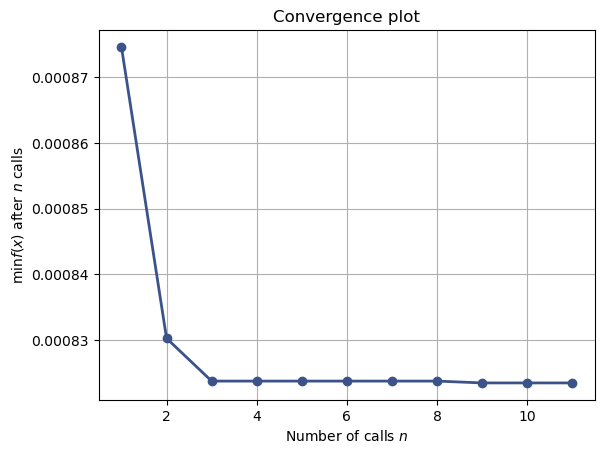

In [58]:
# optimization progress
plot_convergence(search_result)

In [59]:
# best hyper-parameters
print('learning_rate     {}'.format(search_result.x[0]))
print('num_lstm_units    {}'.format(search_result.x[1]))
print('num_epochs        {}'.format(search_result.x[2]))
print('num_batch_size    {}'.format(search_result.x[3]))

learning_rate     0.021439780405494317
num_lstm_units    345
num_epochs        203
num_batch_size    313


In [60]:
print('learning_rate     {}'.format(dimensions[0]))
print('num_lstm_units    {}'.format(dimensions[1]))
print('num_epochs        {}'.format(dimensions[2]))
print('num_batch_size    {}'.format(dimensions[3]))

learning_rate     Real(low=0.001, high=1, prior='log-uniform', transform='normalize')
num_lstm_units    Integer(low=1, high=500, prior='uniform', transform='normalize')
num_epochs        Integer(low=1, high=500, prior='uniform', transform='normalize')
num_batch_size    Integer(low=1, high=500, prior='uniform', transform='normalize')


In [61]:
search_result.fun

0.0008235073764808476

In [62]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(0.0008235073764808476, [0.021439780405494317, 345, 203, 313]),
 (0.0008237854344770312, [0.0010257329286849045, 179, 99, 373]),
 (0.0008302958449348807, [0.03666659315718311, 134, 153, 209]),
 (0.0008705342770554125, [0.019298855136791276, 324, 369, 457]),
 (0.0008745898958295584, [0.01, 100, 100, 100]),
 (0.0008893614285625517, [0.9330200687683032, 32, 171, 59]),
 (0.0009105488425120711, [0.011482896192024332, 399, 261, 452]),
 (0.0009727365104481578, [0.33459654041251685, 223, 230, 82]),
 (0.0009878171840682626, [0.033636161592560894, 7, 136, 88]),
 (0.0010382370091974735, [0.012079336847634192, 12, 249, 499]),
 (0.0015440316637977958, [0.024918597017849747, 344, 16, 416])]

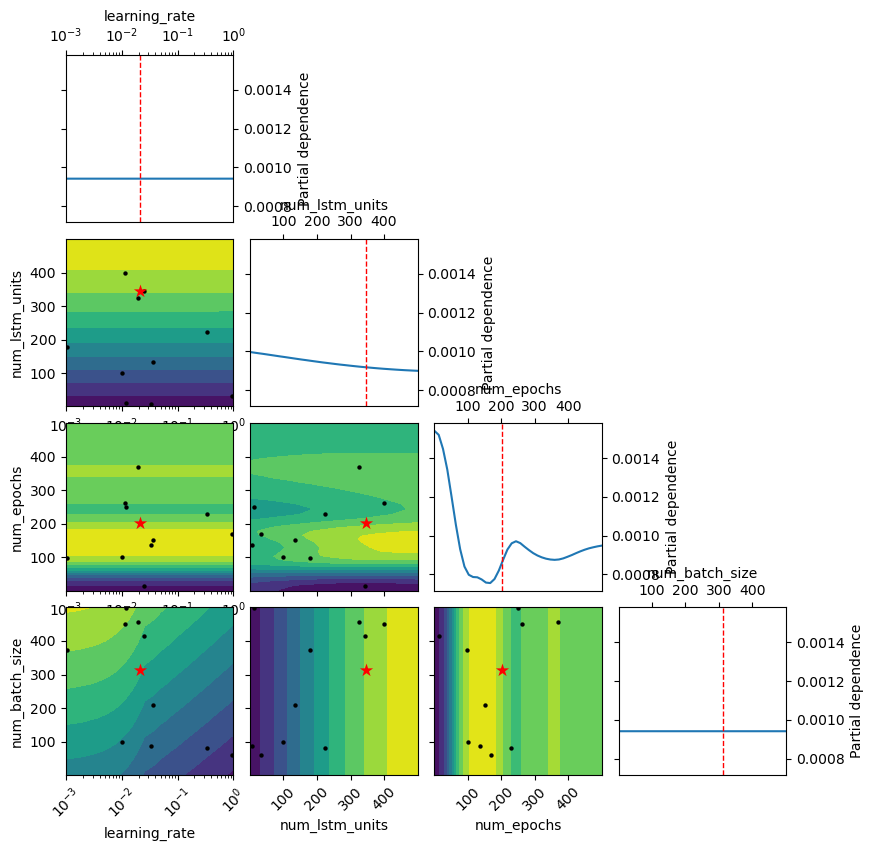

In [63]:
_ = plot_objective(result=search_result)

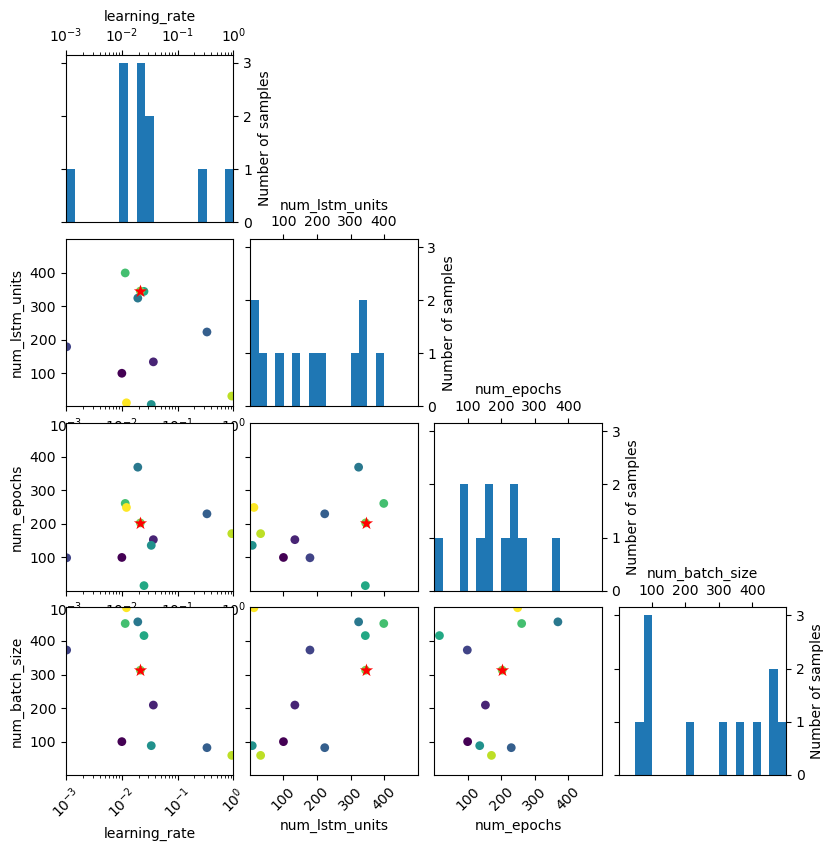

In [64]:
_ = plot_evaluations(result=search_result)

In [24]:
model = load_model(path_best_model)

In [25]:
result = model.evaluate(x=testX,
                        y=testY)

45/45 [==============================] - 4s 59ms/step - loss: 4.6757e-04 - mae: 0.0117


In [67]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.00043720417306758463
mae 0.011064784601330757


In [68]:
print("{0}: {1:.2%}".format(model.metrics_names[0], result[0]))

loss: 0.04%


In [57]:
df['Time'][len(X)]

Timestamp('2020-07-13 00:00:00')

45/45 [==============================] - 3s 58ms/step
Le score R^2 est: 0.9863936304554287
Le mse est: 0.0004675710778548203


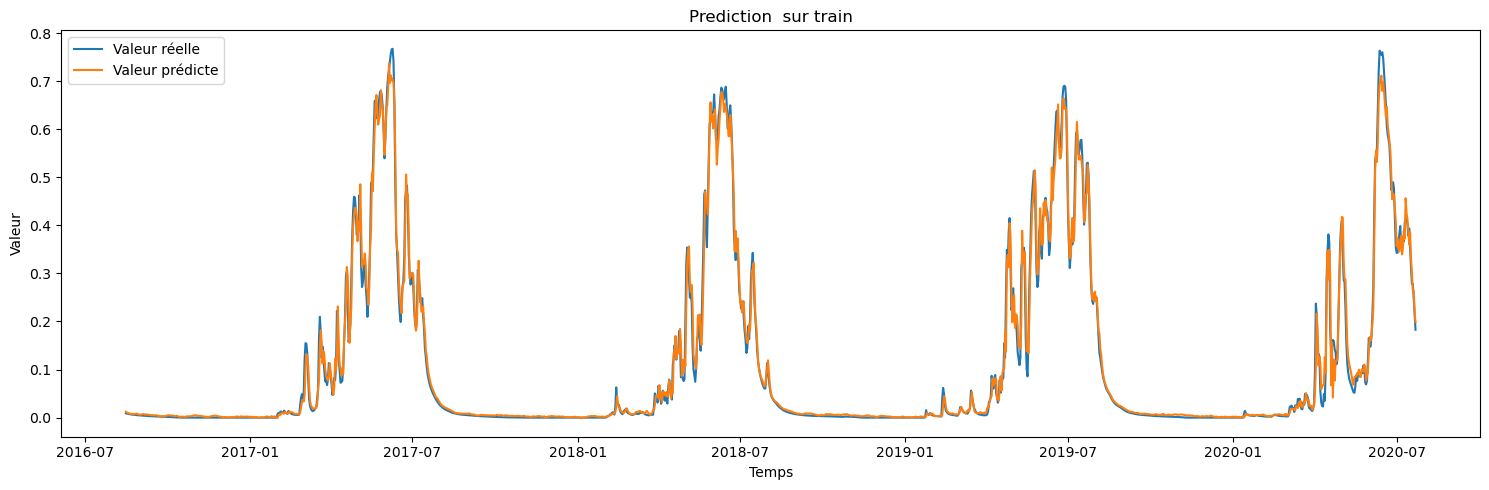

In [27]:
from sklearn.metrics import r2_score, mean_squared_error
# Effectuer des prédictions avec le modèle
y_pred = model.predict(testX)

# Calculer le score R^2
r2 = r2_score(testY, y_pred)
mse = mean_squared_error(testY, y_pred)
print(f"Le score R^2 est: {r2}")
print(f"Le mse est: {mse}")

time_steps = pd.date_range(start='2016-08-16', periods=len(y_pred))

# Tracer les valeurs réelles et prédites
plt.figure(figsize=(15, 5))
plt.plot(time_steps, testY, label='Valeur réelle')
plt.plot(time_steps, y_pred, label='Valeur prédicte')
plt.title('Prediction  sur train')
plt.ylabel('Valeur')
plt.xlabel('Temps')
plt.legend()
plt.tight_layout()
plt.show()

# Prédiction future

In [115]:
# Scaled data est sur la période de janvier 2001 au 31 aout 2020 et look_back = 50

In [132]:
# Préparation des dernières données passées pour les prédictions futures
last_data = scaled_data[-look_back:]

In [133]:
# Prédiction step by step pour décembre 2023
n_future = 7 # du 01 septembre au 07 septembre 2020
predictions = []
for i in range(n_future):  # n_future jours dans le future
    pred = model.predict(last_data[np.newaxis, :, :])[0][0]
    predictions.append(pred)
    # Mise à jour des données avec la prédiction
    # Notez que vous devez inclure des valeurs par défaut pour les autres features
    # Ici, j'utilise les valeurs du dernier jour comme approximation
    new_row = np.append(last_data[-1, 1:], pred)  # Décaler les valeurs et ajouter la prédiction
    last_data = np.vstack([last_data[1:], new_row])

1/1 [==============================] - 0s 27ms/step


In [134]:
# Inverse de la normalisation pour les prédictions
predicted_flow = scaler.inverse_transform(np.column_stack([np.zeros((n_future, 3)), predictions]))[:, -1]

In [136]:
# Afficher les prédictions pour décembre 2023
predicted_dates = pd.date_range(start='2020-09-01', periods=n_future)
predicted_df = pd.DataFrame({'Date': predicted_dates, 'Predicted_Flow': predicted_flow})
print(predicted_df)

        Date  Predicted_Flow
0 2020-09-01      102.720552
1 2020-09-02      109.260443
2 2020-09-03      119.561336
3 2020-09-04      133.966309
4 2020-09-05      152.754112
5 2020-09-06      176.037061
6 2020-09-07      204.048729


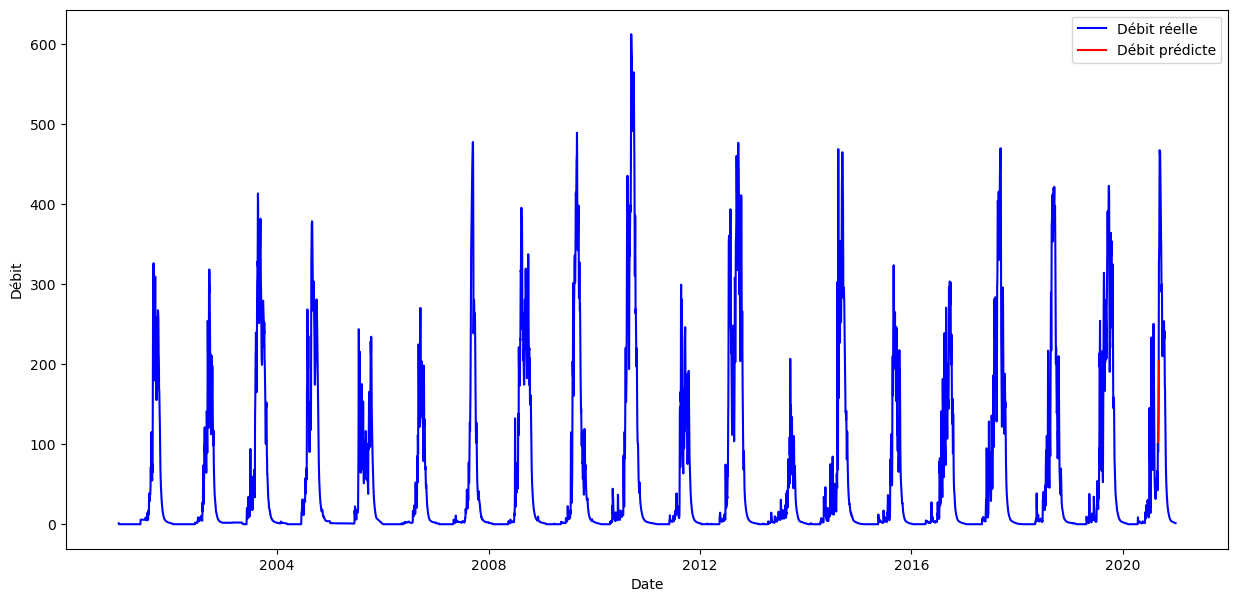

In [139]:
import matplotlib.pyplot as plt
import pandas as pd


# Concaténation des données réelles et des prédictions
all_data = pd.concat([data, data2], ignore_index=True)

# Tracé des données réelles
plt.figure(figsize=(15, 7))
plt.plot(df['Time'], all_data['Débit_Bétérou'], label='Débit réelle', color='blue')

# Tracé des prédictions de décembre 2023
plt.plot(predicted_df['Date'], predicted_df['Predicted_Flow'], label='Débit prédicte', color='red')

plt.xlabel('Date')
plt.ylabel('Débit')
plt.legend()
plt.show()


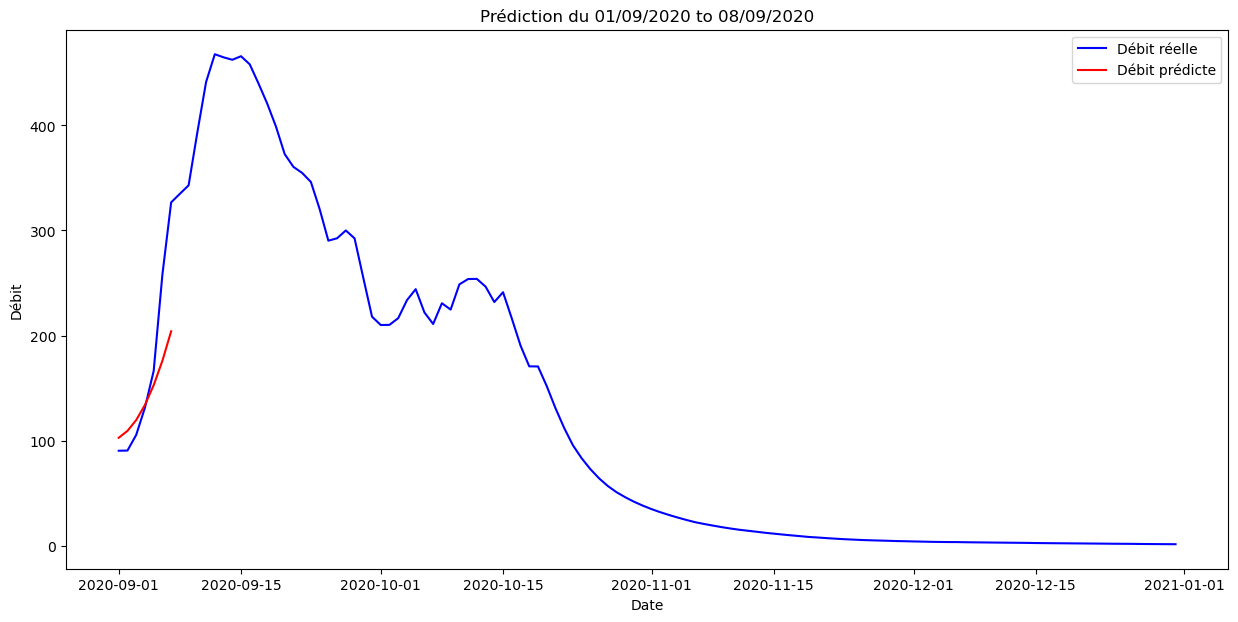

In [140]:
import matplotlib.pyplot as plt
import pandas as pd


# Concaténation des données réelles et des prédictions
all_data = pd.concat([data, data2], ignore_index=True)

# Filtrer pour obtenir les 100 derniers jours
last_100_days = all_data.tail(122)
Time = df['Time'].tail(122)

# Tracé des données réelles
plt.figure(figsize=(15, 7))
plt.plot(Time, last_100_days['Débit_Bétérou'], label='Débit réelle', color='blue')

# Tracé des prédictions de décembre 2023
plt.plot(predicted_df['Date'], predicted_df['Predicted_Flow'], label='Débit prédicte', color='red')

plt.title('Prédiction du 01/09/2020 to 08/09/2020')
plt.xlabel('Date')
plt.ylabel('Débit')
plt.legend()
plt.show()
